# Quantized Transfer Learning for Computer Vision Tutorial

Link: https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html

This tutorial builds on the [original PyTorch Transfer Learning tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html), written by Sasank Chilamkurthy.

Transfer learning refers to techniques that make use of a pretrained model for application on a different data-set. There are two main ways the transfer learning is used:

- **ConvNet as a fixed feature extractor:** Here, you [“freeze”](https://arxiv.org/abs/1706.04983) the weights of all the parameters in the network except that of the final several layers (aka “the head”, usually fully connected layers). These last layers are replaced with new ones initialized with random weights and only these layers are trained.
- **Finetuning the ConvNet:** Instead of random initializaion, the model is initialized using a pretrained network, after which the training proceeds as usual but with a different dataset. Usually the head (or part of it) is also replaced in the network in case there is a different number of outputs. It is common in this method to set the learning rate to a smaller number. This is done because the network is already trained, and only minor changes are required to “finetune” it to a new dataset.

You can also combine the above two methods: First you can freeze the feature extractor, and train the head. After that, you can unfreeze the feature extractor (or part of it), set the learning rate to something smaller, and continue training.

In this part you will use the first method – extracting the features using a quantized model.



## Part 0. Prerequisites

Before diving into the transfer learning, let us review the “prerequisites”, such as installations and data loading/visualizations.

In [1]:
# Imports
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import time

plt.ion()

## Installing the Nightly Build

Because you will be using the beta parts of the PyTorch, it is recommended to install the latest version of torch and torchvision. You can find the most recent instructions on local installation here. For example, to install without GPU support:

In [2]:
# pip install numpy
# pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html
# For CUDA support use https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html

## Load Data

**Note:** This section is identical to the original transfer learning tutorial.

We will use `torchvision` and `torch.utils.data` packages to load the data.

The problem you are going to solve today is classifying **ants** and **bees** from images. The dataset contains about 120 training images each for ants and bees. There are 75 validation images for each class. This is considered a very small dataset to generalize on. However, since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

**Note:** Download the data from [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) and extract it to the `data` directory.

In [3]:
import torch
from torchvision import transforms, datasets

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    "train": transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [5]:
data_dir = "/Users/dongdongdongdong/Desktop/hymenoptera_data"

images_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                           data_transforms[x])
                   for x in ["train", "val"]}

In [6]:
images_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 244
     Root location: /Users/dongdongdongdong/Desktop/hymenoptera_data/train
     StandardTransform
 Transform: Compose(
                Resize(size=224, interpolation=PIL.Image.BILINEAR)
                RandomCrop(size=(224, 224), padding=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'val': Dataset ImageFolder
     Number of datapoints: 153
     Root location: /Users/dongdongdongdong/Desktop/hymenoptera_data/val
     StandardTransform
 Transform: Compose(
                Resize(size=224, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [7]:
dataloaders = {x: torch.utils.data.DataLoader(images_datasets[x],
                                              batch_size=16,
                                              shuffle=True,
                                              num_workers=8)
               for x in ["train", "val"]}

In [8]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fb6e2cb2358>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7fb6e2cb2438>}

In [9]:
dataset_sizes = {x: len(images_datasets[x]) for x in ["train", "val"]}
dataset_sizes

{'train': 244, 'val': 153}

In [10]:
class_names = images_datasets["train"].classes
class_names

['ants', 'bees']

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Visualize a few images

Let’s visualize a few training images so as to understand the data augmentations.

In [12]:
import torchvision

def imshow(inp, title=None):
    """
    Imshow for Tensor.
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

In [13]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))
inputs.shape, classes.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

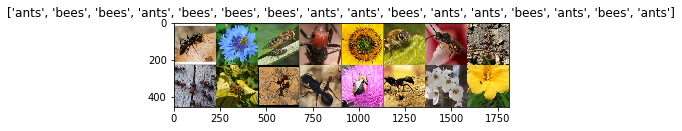

In [14]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Support Function for Model Training

Below is a generic function for model training. This function also:

- Schedules the learning rate.
- Saves the best model.

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15, device="cpu"):
    """
    Support function for model training.
    
    Args:
        model: Model to be trained
        criterion: Optimization criterion (loss)
        optimizer: Optimizer to use for training
        scheduler: Instance of `torch.optim.lr_scheduler`
        num_epochs: Number of epochs
        device: Device to run the training on. Must be 'cpu' or 'cuda'
    """
    
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)
        
        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                iabels = inputs.to(device)
                
                # Zero the paramter gradients
                optimizer.zero_grad()
                
                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        
                    # Statistics
                    runing_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == "train":
                    scheduler.step()
                    
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                
                print("{} Loss: {:.4f} Acc: {:.4f}".format(
                    phase, epoch_loss, epoch_acc))
                
                # Deep copy the model
                if phase == "val" and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    
                print()
                
            time_elapsed = time.time() - since
            print("Training complete in {:.0f}m {:.0f}s".format(
                time_elapsed // 60, time_elapsed % 60))
            print("Best val Acc: {:.4f}".format(best_acc))
            
            # Load the best model weights
            model.load_state_dict(best_model_wts)
            return model

## Support Function for Visualizing the Model Predictions

Generic function to display predictions for a few images

In [16]:
def visualize_model(model, rows=3, cols=3, num_images=6):
    was_training = model.training
    modle.eval()
    images_so_far = 0
    fig, ax = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    
    with torch.no_grad():
        for idx, (imgs, lbls) in enumerate(dataloaders["val"]):
            imgs = imgs.cpu()
            lbls = lbls.cpu()
            
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            
            for jdx in range(imgs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("Pred: {}".format(class_names[preds[jdx]]))
                imshow(imgs.data[jdx])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return 
                
        model.train(mode.was_training)                

## Part 1. Training a Custom Classifier based on a Quantized Feature Extractor

In this section you will use a “frozen” **quantized feature extractor**, and train a custom classifier head on top of it. Unlike floating point models, you don’t need to set `requires_grad=False` for the quantized model, as it has no trainable parameters. Please, refer to the [documentation](https://pytorch.org/docs/stable/quantization.html) for more details.

Load a pretrained model: for this exercise you will be using [ResNet-18](https://pytorch.org/hub/pytorch_vision_resnet/).

In [ ]:
import torchvision.models.quantization as models

In [ ]:
# You will need the number of filters in the `fc` for future use.
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_fe = models.resnet18(pretrained=True, progress=True, quantize=True)
num_ftrs = model_fe.fc.in_features

At this point you need to modify the pretrained model. The model has the **quantize/dequantize blocks** in the beginning and the end. However, because you will only use the feature extractor, the dequantizatioin layer has to move right before the linear layer (the head). The easiest way to do that is to wrap the model in the `nn.Sequential` module.

The first step is to isolate the feature extractor in the ResNet model. Although in this example you are tasked to use all layers except `fc` as the feature extractor, in reality, you can take as many parts as you need. This would be useful in case you would like to replace some of the convolutional layers as well.

**Note:** When separating the feature extractor from the rest of a quantized model, you have to **manually place the quantizer/dequantized in the beginning and the end of the parts** you want to keep quantized.

The function below creates a model with a custom head.

In [18]:
from torch import nn

def create_combined_model(model_fe):
    # Step 1. Isolate the feature extract.
    model_fe_feature = nn.Sequential(
        model_fe.quant, # Quantize the input
        model_fe.conv1,
        model_fe.bn1,
        model_fe.relu,
        model_fe.maxpool,
        model_fe.layer1,
        model_fe.layer2,
        model_fe.layer3,
        model_fe.layer4,
        model_fe.avgpool,
        model_fe.dequant, # Dequantize the output
    )
    
    # Step 2. Create a new "head"
    new_head = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, 2),
    )
    
    # Step 3. Combine, and don't forget the quant stubs.
    new_model = nn.Sequential(
        model_fe_feature,
        nn.Flatten(1),
        new_head,
    )
    
    return new_model

**Warning:** Currently the quantized models can only be run on CPU. However, it is possible to send the non-quantized parts of the model to a GPU.

In [ ]:
import torch.optim as optim

new_model = create_combined_model(model_fe)
new_model = new_model.to("cpu")

criterion = nn.CrossEntropyLoss()

# Note that we are only training the head.
optimizer_ft = torch.optim.SGD(new_model.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train and evaluate

This step takes around 15-25 min on CPU. Because the quantized model can only run on the CPU, you cannot run the training on GPU.

In [ ]:
new_model = train_model(new_model, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=25, device="cpu")

visualize_model(new_model)
plt.tight_layout()

## Part 2. Finetuning the Quantizable Model

In this part, we fine tune the feature extractor used for transfer learning, and quantize the feature extractor. Note that in both part 1 and 2, the feature extractor is quantized. The difference is that in part 1, we use a pretrained quantized model. In this part, we create a quantized feature extractor after fine tuning on the data-set of interest, so this is a way to get better accuracy with transfer learning while having the benefits of quantization. Note that in our specific example, the training set is really small (120 images) so the benefits of fine tuning the entire model is not apparent. However, the procedure shown here will improve accuracy for transfer learning with larger datasets.

The pretrained feature extractor must be quantizable. To make sure it is quantizable, perform the following steps:

- Fuse `(Conv, BN, ReLU)`, `(Conv, BN)`, and `(Conv, ReLU)` using `torch.quantization.fuse_modules`.
- Connect the feature extractor with a custom head. This requires dequantizing the output of the feature extractor.
- Insert fake-quantization modules at appropriate locations in the feature extractor to mimic quantization during training.

For step (1), we use models from `torchvision/models/quantization`, which have a member method `fuse_model`. This function fuses all the `conv`, `bn`, and `relu` modules. For custom models, this would require calling the `torch.quantization.fuse_modules` API with the list of modules to fuse manually.

Step (2) is performed by the `create_combined_model` function used in the previous section.

Step (3) is achieved by using `torch.quantization.prepare_qat`, which inserts fake-quantization modules.

As step (4), you can start “finetuning” the model, and after that convert it to a fully quantized version (Step 5).

To convert the fine tuned model into a quantized model you can call the `torch.quantization.convert` function (in our case only the feature extractor is quantized).

**Note:** Because of the random initialization your results might differ from the results shown in this tutorial.



In [ ]:
# notice quantize=False model = models.resnet18(pretrained=True, progress=True, quantize=False) num_ftrs = model.fc.in_features

# Step 1 model.train() model.fuse_model() 
# Step 2 model_ft = create_combined_model(model) model_ft[0].qconfig = torch.quantization.default_qat_qconfig # Use default QAT configuration 
# Step 3 model_ft = torch.quantization.prepare_qat(model_ft, inplace=True)

## Finetuning the model

In the current tutorial the whole model is fine tuned. In general, this will lead to higher accuracy. However, due to the small training set used here, we end up overfitting to the training set.

Step 4. Fine tune the model:

In [ ]:
for param in model_ft.parameters():
    param.requires_grad = True
    
model_ft.to(device) # We can fine-tune on GPU if applicable

criterion = nn.CrossEntropyLoss()

# Note that we are training everything, so the learning rate is lower
# Notice the smaller learning rate
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)

# Decay LR by a factor 0.3 every several epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.3)

model_ft_tuned = train_model(model_ft, criterion, optimizer_ft,
                             exp_lr_scheduler, num_epochs=25, device=device)

Step 5. Convert to quantized model:

In [ ]:
from torch.quantization import convert

model_ft_tuned.cpu()

model_quantized_and_trained = convert(model_ft_tuned, inplace=False)

Lets see how the quantized model performs on a few images:

In [ ]:
visualize_model(model_quantized_and_trained)

plt.ioff()
plt.tight_layout()
plt.show()